In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## Read in data and create time features

In [2]:
project_6d8c = pd.read_csv('../../capstone_data/Azimuth/project_34a6.csv')
project_6d8c.dropna(inplace=True)
project_6d8c.info()

project_6d8c['t'] = pd.to_datetime(project_6d8c['t'], format='%Y-%m-%d %H:%M:%S')
project_6d8c.sort_values('t',inplace=True)
project_6d8c = project_6d8c.set_index('t')
project_6d8c['year'] = project_6d8c.index.year
project_6d8c['month'] = project_6d8c.index.month
project_6d8c['day'] = project_6d8c.index.day
project_6d8c['dayofweek'] = project_6d8c.index.dayofweek
project_6d8c['hour'] = project_6d8c.index.hour

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21388 entries, 140 to 23828
Data columns (total 9 columns):
project_id    21388 non-null object
t             21388 non-null object
relay         21388 non-null float64
load_v1rms    21388 non-null float64
load_v2rms    21388 non-null float64
load_v3rms    21388 non-null float64
load_i1rms    21388 non-null float64
load_i2rms    21388 non-null float64
laod_i3rms    21388 non-null float64
dtypes: float64(7), object(2)
memory usage: 1.6+ MB


## Reduce Relay signal to 0s and 1s

In [3]:
project_6d8c['relay_est'] = project_6d8c['relay'].apply(lambda x: 0 if x == 1.0 else 1)

In [4]:
project_6d8c['relay_est'].value_counts()

0    21238
1      150
Name: relay_est, dtype: int64

## Identify records where time continuity is broken

In [5]:
# tagging periods where the proceeding datapoint is not 5 minutes
time = pd.Series(project_6d8c.index)
time2 = pd.Series(project_6d8c.index).shift(1)
ser = pd.Series(time - time2)
ser = ser.apply(lambda x: None if x!=pd.to_timedelta('0 days 00:05:00')else 1)
project_6d8c['t_diff']= pd.Series(ser).values

## Plots for examining data

In [6]:
def plot_all_data(df,columns):
    years = df['year'].unique()
    y_m_combinations = []
    for y in years: 
        months = df[(df['year'] == y)]['month'].unique()
        for m in months:
            y_m = (y,m)
            y_m_combinations.append(y_m)

    fig, axs = plt.subplots(len(y_m_combinations), figsize=(14, 5*len(y_m_combinations)))
    for ax, c in zip(axs,y_m_combinations):
        temp = df[(df['year'] == c[0]) & (df['month'] == c[1])]
        for col in columns:
            ax.plot(temp.index, temp[col]/df[col].max())
        ax.set_title('timeseries for {}, {}'.format(c[0],c[1]))
    plt.show()
    pass

In [7]:
def plot_time_frame(df,start,end,columns):
    '''
    Plot the timeseries for a given period of time
    PARAMETERS
    ------------
    df : Pandas DataFrame with DatetimeIndex
    start: string in format 'YYYY-MM-DD HH:MM:SS'
    end: string in format 'YYYY-MM-DD HH:MM:SS'
    columns: list of column names
    RETURNS
    -------
    None: plots the graphs
    '''
    temp = df.loc[(df.index>=start)&(df.index<end)]
    years = temp['year'].unique()
    y_m_combinations = []
    for y in years: 
        months = temp[(temp['year'] == y)]['month'].unique()
        for m in months:
            y_m = (y,m)
            y_m_combinations.append(y_m)
    
    if len(y_m_combinations) ==1:
        temp2 = temp[(temp['year'] == y_m_combinations[0][0]) & (temp['month'] == y_m_combinations[0][1])]
        plt.figure(figsize=(14,4))
        for col in columns:
            plt.plot(temp2.index, temp2[col]/df[col].max())
        plt.title('timeseries for {}, {}'.format(y_m_combinations[0][0],y_m_combinations[0][0]))
        
    else:
        fig, axs = plt.subplots(len(y_m_combinations), figsize=(14, len(y_m_combinations)*4))
        for ax, c in zip(axs,y_m_combinations):
            temp2 = temp[(temp['year'] == c[0]) & (temp['month'] == c[1])]
            for col in columns:
                ax.plot(temp2.index, temp2[col]/df[col].max())
            ax.set_title('timeseries for {}, {}'.format(c[0],c[1]))
    plt.show()
    pass

In [8]:
project_6d8c.index.min()

Timestamp('2016-10-12 12:35:00')

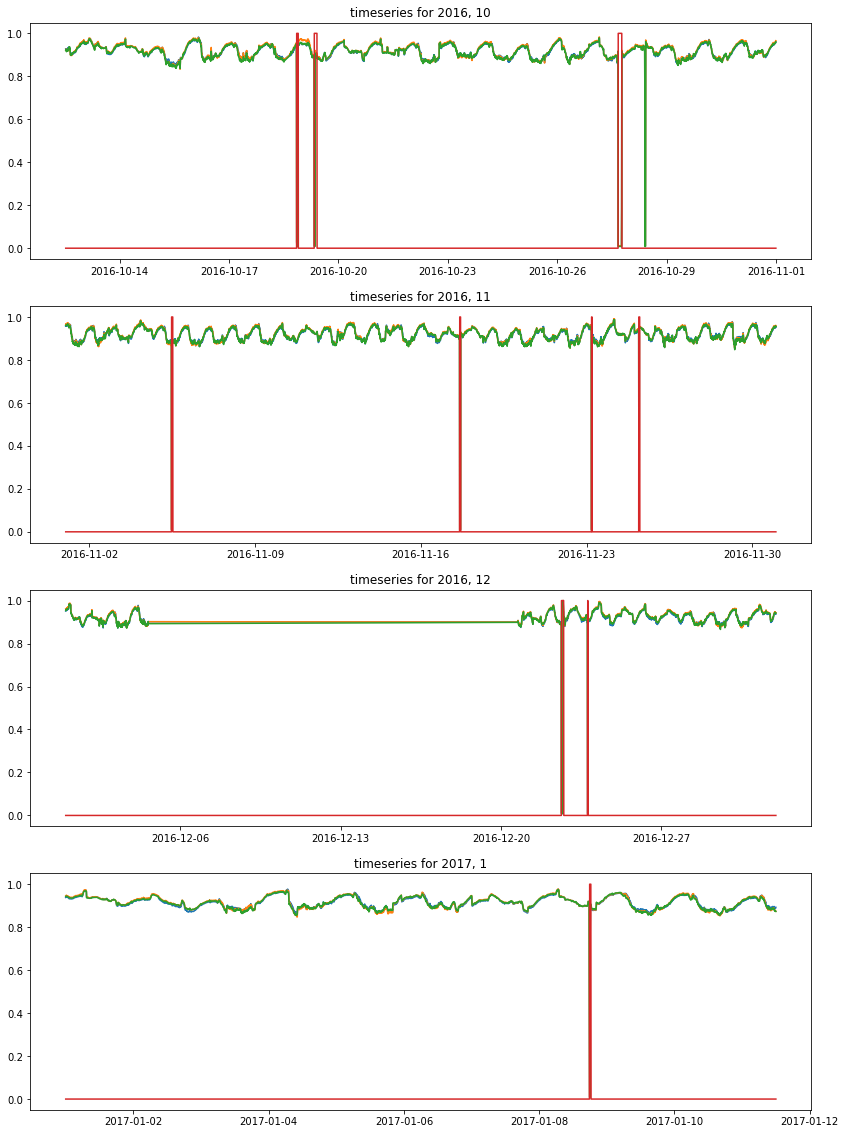

In [9]:
plot_all_data(project_6d8c, columns=['load_v1rms','load_v2rms','load_v3rms','relay_est'])

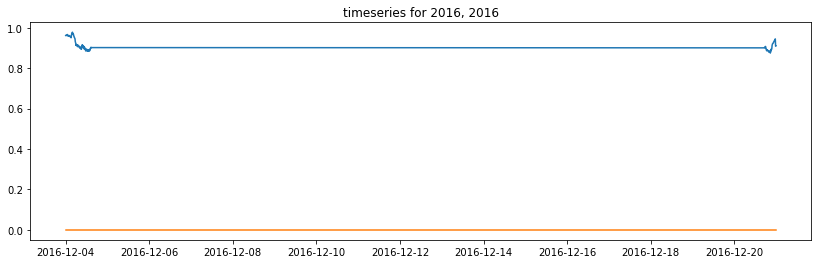

In [15]:
plot_time_frame(project_6d8c,'2016-12-04 00:00:00','2016-12-21 00:00:00',columns=['load_v1rms','relay_est'])

In [23]:
bad_data = [('2016-12-04 00:00:00','2017-02-01 00:00:00')]

## Function to label and remove bad data periods

In [24]:
def label_bad_data(df, dates):
    df['data_issue']=0
    for d in dates:
        df.loc[(df.index>=d[0])&(df.index<d[1]),'data_issue'] = 1
    return df

In [25]:
df = label_bad_data(project_6d8c, bad_data)
df.data_issue.value_counts()

0    14998
1     6390
Name: data_issue, dtype: int64

In [26]:
def remove_time_period(df,start, end):
    new_df = df.loc[~((df.index>=start)&(df.index<end))]
    return new_df

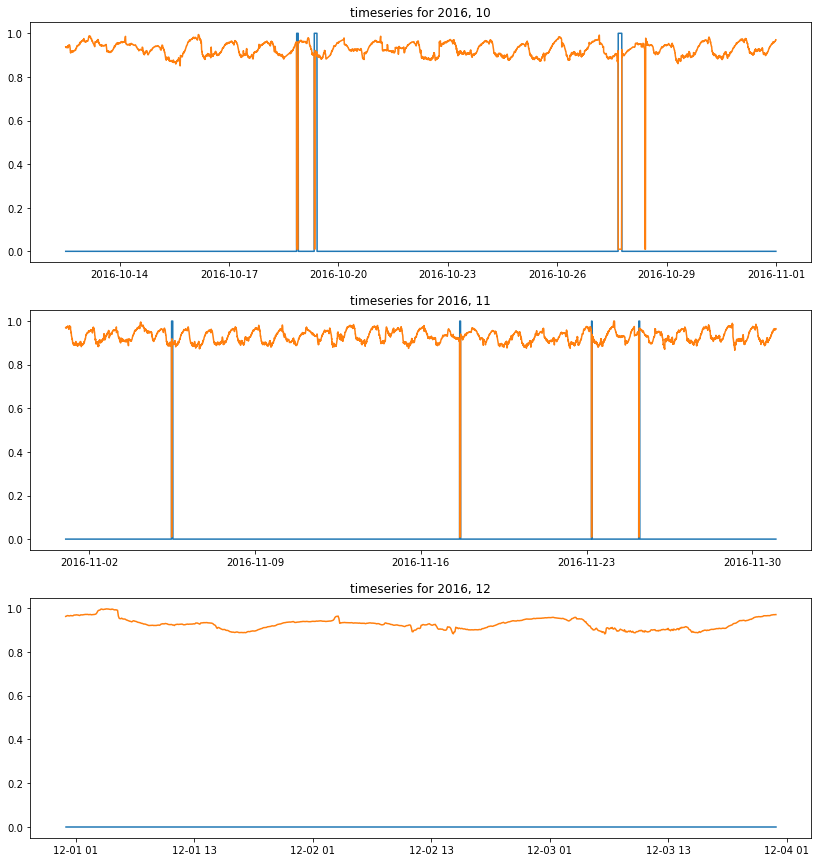

In [27]:
df2 = df[df['data_issue']!=1]
plot_all_data(df2, ['relay_est','load_v1rms'])

## Write data to csv

In [33]:
df2.to_csv('../../capstone_data/Azimuth/clean/project_34a6_clean.csv', index=True)

### Checking Power

In [31]:
df2['power_1'] = df2['load_v1rms']*df2['load_i1rms']
df2['power_2'] = df2['load_v2rms']*df2['load_i2rms']
df2['power_3'] = df2['load_v3rms']*df2['laod_i3rms']
df2['power_all'] = df2['power_1'] +df2['power_2'] + df2['power_3']

/home/rosina/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/rosina/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/rosina/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

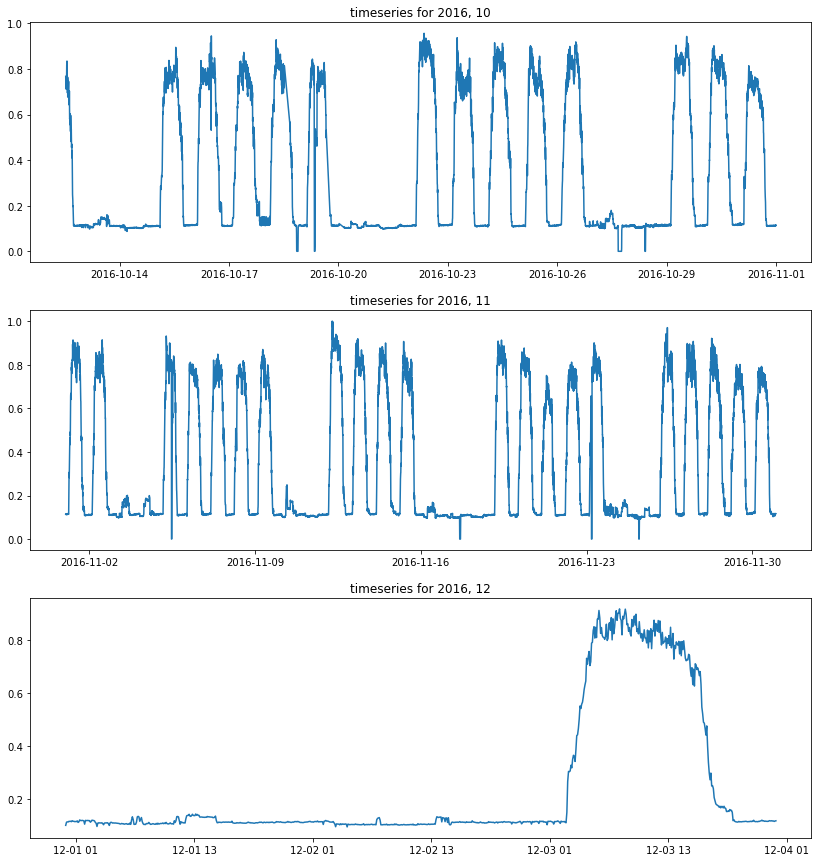

In [32]:
plot_all_data(df2, ['power_all'])